# Construction images classification

Install cuda and  pytorch  cuda vision 10.2    pytorch vision 1.11.0

you can find how to install cuda in https://developer.nvidia.com/cuda-10.2-download-archive

how to install pytorch in https://pytorch.org/get-started/previous-versions/

you can find the code in pytorch-image-classification-master folder

This assignment is for picture classification using the Resnet network.

ResNet was introduced by Microsoft LABS in 2015 and won first place in the ImageNet competition for classification task and first place in object detection. It won the first place in object detection and image segmentation in COCO dataset.

Deep Residual Learining for Image Recognition

I'm going to go through each of them. (Py file). Include its content and function. At the end you will talk about how to use your computer for training and testing.

In config.py   we define the Network parameters and picture paths.

# Datasets

We collected pictures in 4 construction site scenes for classification. Such as workers,bulldozer,trucks,grab.in input_data folder.

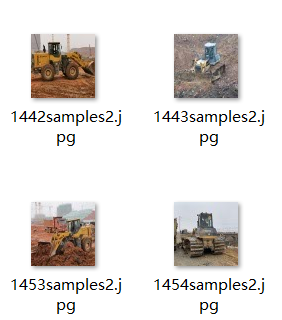




In [4]:
class MyConfigs():

    data_folder = './input_data/'  
    test_data_folder = ""
    model_name = "resnet" #Vgg ResNet152 myModel
    weights = "./checkpoints/"
    logs = "./logs/"
    example_folder = "./example/"
    freeze = True
    #
    epochs = 300
    batch_size = 16
    img_height = 227  
    img_width = 227
    num_classes = 20
    lr = 1e-2
    lr_decay = 1e-4
    weight_decay = 2e-4
    ratio = 0.2
config = MyConfigs()


In dataset.py  we define  how to Read the Images

In [ ]:
import torch
from torch.utils.data import Dataset,DataLoader
import cv2
import os
from tqdm import tqdm
from config import config
from glob import glob
import os
from torchvision import transforms
import numpy as np
import random
from shutil import copy
from PIL import Image
import math

np.random.seed(666) #设置随机种子 为了保证每次划分训练集和测试机的是相同的


'''
# 1. 对于mini_data　数据集的解析
def parse_data_config(data_path):
    files = []
    #
    for img in os.listdir(data_path):
        image = data_path + img
        label = img.split("__")[0][3:]
        files.append((image,label))
    return files

#划分训练集和测试集
# ratio 为划分为测试集的比例
def divide_data(data_path,ratio):
    files = parse_data_config(data_path)
    temp = np.array(files)
    test_data = []
    train_data = []
    for i in range(config.num_classes):
        temp_data = []
        for data in temp:
            if data[1] == str(i):
                temp_data.append(data)
        np.random.shuffle(np.array(temp_data))
        test_data =test_data + temp_data[:int(ratio * len(temp_data))]
        train_data = train_data + temp_data[int(ratio*len(temp_data))+1:]
    # np.random.shuffle(temp)
    # test_data = files[:int(ratio * len(files))]
    # train_data = files[int(ratio*len(files))+1:]

    # 从训练集中挑选 10 中图片保存到 example 文件夹中
    if not os.path.exists(config.example_folder):
        os.mkdir(config.example_folder)
    else:
        for i in os.listdir(config.example_folder):
            os.remove(os.path.join(config.example_folder+i))
    for i in range(10):
        index = random.randint(0,len(test_data)-1)  # 随机生成图片的索引
        copy(test_data[index][0],config.example_folder)  # 将挑选的图像复制到example文件夹

    return test_data, train_data
'''
# 2. 对于civl数据集的解析
def get_files(file_dir,ratio):
    grab = []
    labels_grab = []
    worker = []
    labels_worker = []
    bulldozer = []
    labels_bulldozer=[]
    truck = []
    labels_truck = []
    for file  in os.listdir(file_dir +'grab'):
        grab.append(file_dir + 'grab' + '/' + file)
        labels_grab.append(0)
    for file in os.listdir(file_dir + 'worker'):
        worker.append(file_dir + 'worker' + '/' + file)
        labels_worker.append(1)
    for file in os.listdir(file_dir + 'bulldozer'):
        worker.append(file_dir + 'bulldozer' + '/' +file)
        labels_bulldozer.append(2)
    for file in os.listdir(file_dir + 'truck'):
        truck.append(file_dir + 'truck' + '/' +file)
        labels_truck.append(3)

    image_list = np.hstack((grab ,worker, bulldozer, truck))
    labels_list = np.hstack((labels_grab, labels_worker, labels_bulldozer, labels_truck))
    temp = np.array([image_list, labels_list])
    temp = temp.transpose()
    np.random.shuffle(temp)
    all_image_list = list(temp[:,0])
    all_label_list = list(temp[:,1])
    all_label_list = [int(i) for i in all_label_list]
    length = len(all_image_list)
    n_test = int(math.ceil(length * ratio))
    n_train = length - n_test

    tra_image = all_image_list[0:n_train]
    tra_label = all_label_list[0:n_train]

    test_image = all_image_list[n_train:-1]
    test_label = all_label_list[n_train:-1]

    train_data = [(tra_image[i],tra_label[i]) for i in range(len(tra_image))]
    test_data = [(test_image[i],test_label[i]) for i in range(len(test_image))]
   # print("train_data = ",test_image)
   # print("test_data = " , test_label)
    return test_data,train_data

#这个数据集类的作用就是加载训练和测试时的数据
class datasets(Dataset):
    def __init__(self,data,transform = None,test = False):
        imgs = []
        labels = []
        self.test = test
        self.len = len(data)
        self.data = data
        self.transform = transform
        for i in self.data:
            imgs.append(i[0])
            self.imgs = imgs
            labels.append(int(i[1]) ) #pytorch中交叉熵需要从0开始
            self.labels  = labels
    def __getitem__(self,index):
        if self.test:
            filename = self.imgs[index]
            filename = filename
            img_path = self.imgs[index]
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (config.img_width, config.img_height))
            img = transforms.ToTensor()(img)
            return img,filename
        else:
            img_path = self.imgs[index]
            label = self.labels[index]
            #label = int(label)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = cv2.resize(img,(config.img_width,config.img_height))
            # img = transforms.ToTensor()(img)

            if self.transform is not None:
                img = Image.fromarray(img)
                img = self.transform(img)

            else:
                img = transforms.ToTensor()(img)
            return img,label

    def __len__(self):
        return len(self.data)#self.len

def collate_fn(batch): #表示如何将多个样本拼接成一个batch
    imgs = []
    label = []
    for sample in batch:
        imgs.append(sample[0])
        label.append(sample[1])

    return torch.stack(imgs, 0),label


#用于调试代码
if __name__ == '__main__':
    test_data,_ = get_files(config.data_folder,0.2)
    for i in (test_data):
        print(i)
    print(len(test_data))

    transform = transforms.Compose([transforms.ToTensor()])
    data = datasets(test_data,transform = transform)
    #print(data[0])

In Model.py  Build a simple convolutional neural network  res18 and res 101

In [ ]:
import numpy as np
import torch
import torchvision
from torch import nn,optim
from config import config



def l2_norm(x):
    norm = torch.norm(x,p =2 ,dim =1 ,keepdim= True)
    x = torch.div(x,norm)
    return x
# 自己搭建一个简单卷积神经网络
class myModel(nn.Module):
    def __init__(self,num_classes):
        super(myModel,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,3), #in_channels out_channels kernel_size
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size= 2,stride = 2)  #149
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,3,2),  #74    #
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size =2,stride=2)  #37

        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,32,3,2),  #18
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size= 2, stride = 2)  #9
        )
        self.fc1 = nn.Sequential(
            nn.Linear(2592,120),
            nn.ReLU(True)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(120,84),
            nn.ReLU(True),
            nn.Linear(84,num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x



class ResNet18(nn.Module):
    def __init__(self,model,num_classes = 1000):
        super(ResNet18,self).__init__()
        self.backbone = model

        self.fc1 = nn.Linear(512,1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024,num_classes)
    def forward(self, x):
        x = self.backbone.conv1(x)
        x= self.backbone.bn1 (x)
        x = self.backbone.relu(x)
        x= self.backbone.maxpool(x)

        x= self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x= self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)

        x= x.view(x.size(0),-1)
        x= l2_norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = l2_norm(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
class ResNet101(nn.Module):
    def __init__(self,model,num_classes =1000):
        super(ResNet101,self).__init__()
        self.backbone = model

        self.fc1 = nn.Linear(2048,2048)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(2048,num_classes)

    def forward(self,x):
        x = self.backbone.conv1(x)
        x =  self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)

        x = x.view(x.size(0),-1)
        x = l2_norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = l2_norm(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

def get_net():
    #backbone = torchvision.models.resnet18(pretrained=True)
    #models = ResNet18(backbone,config.num_classes)
    backbone = torchvision.models.resnet101(pretrained=True)
    models = ResNet101(backbone, config.num_classes)
    return models

In utils.py   Define some functions to be used, such as saving model to calculate model accuracy and so on. To prepare for our subsequent training and testing.

In [ ]:
#This file include some functions
from config import config
import torch
import os
import shutil


# Save the model
def save_checkpoint(state, save_model):
    filename = config.weights + config.model_name + ".pth" #os.sep在linux下为‘/’
    torch.save(state, filename)
    if save_model:
        message = config.weights + config.model_name+ '.pth'
        print("Get Better top1 : %s saving weights to %s"%(state["accTop1"],message))
        with open("./logs/%s.txt"%config.model_name,"a") as f:
            print("Get Better top1 : %s saving weights to %s"%(state["accTop1"],message),file=f)


# Calculate the accuracy of the model
def accuracy(output,target,topk = (1, 5)):
    '''precision top1 and top5'''
    maxk = max(topk)
    batch_size = target.size(0)  # size(0) = batch_size  size(1) = num_classes
    _, pred = output.topk(maxk, 1, True, True)  
    pred = pred.t() 
    correct = pred.eq(target.view(1,-1).expand_as(pred))  #

    res =[]
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0,keepdim =True) #correct[:k]
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def lr_step(epoch):
    if epoch < 30:
        lr = 0.01
    elif epoch < 80:
        lr = 0.001
    elif epoch < 120:
        lr = 0.0005
    else:
        lr = 0.0001
    return lr


 In train.py  1.Create a model folder 2.Define the model 3.Whether to load CHECKPOINTS training 4.Define the training set and test set 5. Start train

In [ ]:
import numpy as np
import torch
import torchvision
import os
from config import config
import Model
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from datasets import *
from test import *
from utils import*
if __name__ == '__main__' :
    # 1.创建文件夹
    if not os.path.exists(config.example_folder):
        os.mkdir(config.example_folder)
    if not os.path.exists(config.weights):
        os.mkdir(config.weights)
    if not os.path.exists(config.logs):
        os.mkdir(config.logs)


    # 2 定义模型
    model = Model.get_net()
    if torch.cuda.is_available():
        model =model.cuda()

    #print(model)


    optimizer = optim.SGD(model.parameters(), lr=config.lr, momentum=0.9, weight_decay=config.weight_decay)
    criterion = nn.CrossEntropyLoss().cuda()

    # 3.是否需要加载checkpoints 训练
    start_epoch = 0
    current_accuracy = 0
    resume = False  #false不加载模型
    if resume:
        checkpoint = torch.load(config.weights+ config.model_name+'.pth')
        start_epoch = checkpoint["epoch"]
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])

    # 4. 定义训练集 测试集
    transform = transforms.Compose([
                                    transforms.RandomResizedCrop(90),
                                    transforms.ColorJitter(0.05, 0.05, 0.05),
                                    transforms.RandomRotation(30),
                                    transforms.RandomGrayscale(p = 0.5),
                                    transforms.Resize((config.img_width, config.img_height)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
    #transform = transforms.Compose([transforms.ToTensor()])

    #_, train_list = divide_data(config.data_folder,config.ratio)
    _, train_list = get_files(config.data_folder,config.ratio)
    input_data = datasets(train_list,transform= transform)
    #train_data = DataLoader(input_data)
    train_loader = DataLoader(input_data,batch_size = config.batch_size,shuffle = True,collate_fn = collate_fn ,pin_memory=False,num_workers=4)

    #测试集 不要数据增强 transform = None
    #test_list, _=divide_data(config.data_folder,config.ratio)
    test_list, _ = get_files(config.data_folder, config.ratio)
    test_loader = DataLoader(datasets(test_list,transform = None),batch_size= config.batch_size,shuffle =False,collate_fn = collate_fn,num_workers=4)

    #设置动态变换的学习率 lr每经过50个epoch 就变为原来的0.1倍
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)


    train_loss = []
    acc = []
    test_loss = []
    #5. 开始训练
    print("------ Start Training ------\n")
    for epoch in range(start_epoch,config.epochs):
        model.train()
        config.lr = lr_step(epoch)
        optimizer = optim.SGD(model.parameters(), lr=config.lr, momentum=0.9, weight_decay=config.weight_decay)

        loss_epoch = 0
        for index,(input,target) in enumerate(train_loader): #inpu.size(0) = batch_size = 16
            model.train()

            input = Variable(input).cuda()
            target = Variable(torch.from_numpy(np.array(target)).long()).cuda()
            output = model(input)
            loss = criterion(output,target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_epoch += loss.item()

            if (index+1) % 10 == 0:
                print("Epoch: {} [{:>3d}/{}]\t Loss: {:.6f} ".format(epoch+1,index*config.batch_size,len(train_loader.dataset),loss.item()))
        if (epoch+1) % 1 ==0:
            print("\n------ Evaluate ------")
            model.eval()
            # evaluate the model on the test data
            test_loss1, accTop1 = evaluate(test_loader,model,criterion)
            acc.append(accTop1)
            print("type(accTop1) =",type(accTop1))
            test_loss.append(test_loss1)
            train_loss.append(loss_epoch/len(train_loader))
            print("Test_epoch: {} Test_accuracy: {:.4}% Test_Loss: {:.6f}".format(epoch+1,accTop1,test_loss1))
            save_model = accTop1 > current_accuracy #测试的准确率大于当前准确率为True
            accTop1 = max(current_accuracy,accTop1)
            current_accuracy = accTop1
            save_checkpoint({
                "epoch": epoch + 1,
                "model_name": config.model_name,
                "state_dict": model.state_dict(),
                "accTop1": current_accuracy,
                "optimizer": optimizer.state_dict(),
            }, save_model)



Train process.

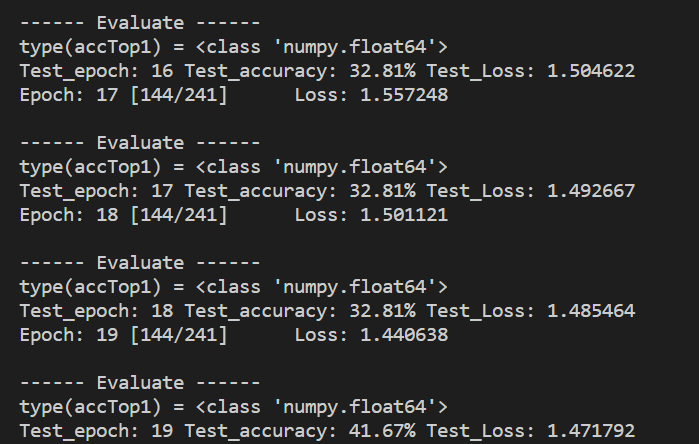



In test.py   We use  model to test some images and results are in resnet.txt.


In [ ]:
import torch
import cv2
import torch
from torch.utils.data import DataLoader
from torch import nn ,optim
from torch.autograd import Variable
from config import config
from datasets import *
import Model
from utils import accuracy
classes= {0:"grab",1:"worker",2:"bulldozer",3:"truck"}

#用于评估模型
def evaluate(test_loader,model,criterion):
    sum = 0
    test_loss_sum = 0
    test_top1_sum = 0
    model.eval()

    for ims, label in test_loader:
        input_test = Variable(ims).cuda()
        target_test = Variable(torch.from_numpy(np.array(label)).long()).cuda()
        output_test = model(input_test)
        loss = criterion(output_test, target_test)
        top1_test = accuracy(output_test, target_test, topk=(1,))
        sum += 1
        test_loss_sum += loss.data.cpu().numpy()
        test_top1_sum += top1_test[0].cpu().numpy()[0]
    avg_loss = test_loss_sum / sum
    avg_top1 = test_top1_sum / sum
    return avg_loss, avg_top1


def test(test_loader,model):
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    predict_file = open("%s.txt" % config.model_name, 'w')
    for i, (input,filename) in enumerate(tqdm(test_loader)):
        if torch.cuda.is_available():
            input = Variable(input).cuda()
        else:
            input= Variable(input)
        #print("input.size = ",input.data.shape)
        y_pred = model(input)
        smax = nn.Softmax(1)
        smax_out = smax( )
        pred_label = np.argmax(smax_out.cpu().data.numpy())
        predict_file.write(filename[0]+', ' +classes[pred_label]+'\n')
        #print(filename[0],"的预测的结果为：",labelText[pred_label])


def test_one_image(image,model):


    model.eval()
    image=cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (config.img_height, config.img_width))
    img = transforms.ToTensor()(image)
    img = img.unsqueeze(0)  # 增加一个维度

    img = Variable(img)


    y_pred = model(img)
    smax = nn.Softmax(1)
    smax_out = smax(y_pred)
    pred_label = np.argmax(smax_out.cpu().data.numpy())
    
    

    if pred_label == 0:
        result = print('这是grab的概率为：%.4f'%smax_out.cpu().data.numpy()[0][pred_label])

    elif pred_label == 1:
        result = print('这是worker的概率为：%.4f' % smax_out.cpu().data.numpy()[0][pred_label])
    elif pred_label ==2:
        result = print('这是bulldozer的概率为：%.4f' % smax_out.cpu().data.numpy()[0][pred_label])
    elif pred_label == 3:
        result = print('这是truck的概率为：%.4f' % smax_out.cpu().data.numpy()[0][pred_label])

    return result

if __name__ == '__main__':

    #1. 定义测试集
    test_list, _ = get_files(config.data_folder,config.ratio)
    test_loader = DataLoader(datasets(test_list, transform=None,test = True), batch_size= 1, shuffle=False,
                             collate_fn=collate_fn, num_workers=4)   # 测试时这里的batch_size = 1

    #2. 加载模型及其参数
    model = Model.get_net()
    checkpoint = torch.load(config.weights+ config.model_name+'.pth')
    model.load_state_dict(checkpoint["state_dict"])
    #optimizer.load_state_dict(checkpoint["optimizer"])
    print("Start Test.......")
    test(test_loader,model)
  

Test result.
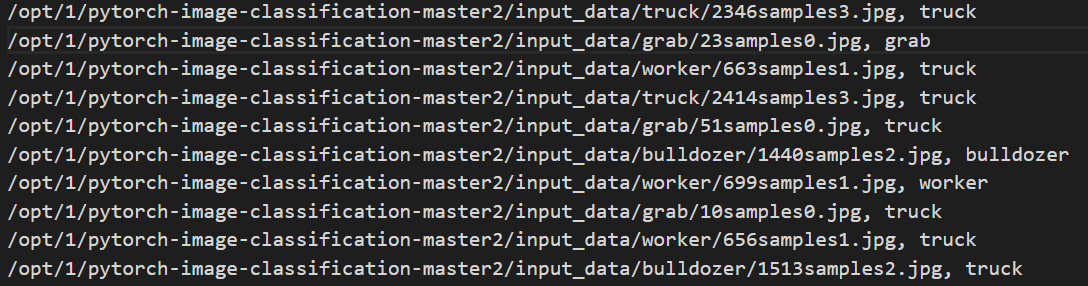

Because the data set we collected is limited, with only 300 images (usually thousands of images are needed for training), the classification model cannot learn the features of each image well when learning. So the test results are not very good. If the data set is large enough, such as 5000, the classification results can be greatly improved.


# How to run the test or train code?

1.Open the anaconda prompt.

2.Make sure you have the required libraries installed  (cuda,pytorch,numopy,cv2 etc).  

3.Go to the folder where the program resides( exp: cd C:\Users\12707\Desktop\pytorch-image-classification-master).

4.python test.py or train.py
We hace train a model in chechpoint fold, you can use it.
(If you have not some lib or model, you could conda install xxx,or google how to install).